In [2]:
# all the packages you need
from __future__ import division
import sys
import numpy as np
import time
import scipy.io as io
import scipy.sparse as sparse
import matplotlib.pyplot as plt
%matplotlib inline

In [226]:
# synthetic data generator
# n is number of samples, d is number of dimensions, k is number of nonzeros in w, sigma is std of noise,
# X is a n x d data matrix, y=Xw+w_0+noise is a n-dimensional vector, w is the true weight vector, w0 is true intercept
def DataGenerator(n = 50, d = 75, k = 5, sigma = 1.0, w0 = 0.0, seed = 256):

    np.random.seed(seed)
    X = np.random.normal(0,1,(n,d))
    w = np.random.binomial(1,0.5,k)
    noise = np.random.normal(0,sigma,n)
    w[w == 1] = 10.0
    w[w == 0] = -10.0
    w = np.append(w, np.zeros(d - k))
    y = X.dot(w) + w0 + noise
    return (X, y, w, w0)

In [3]:
# initialization of W for lasso by least square regression or ridge regression
def Initialw(X, y):

    n, d = X.shape
    # increment X
    if sparse.issparse(X):
        XI = sparse.hstack((X, np.ones(n).reshape(n,1)))
    else:
        XI = np.hstack((X, np.ones(n).reshape(n,1)))

    if sparse.issparse(X):
        if n >= d:
            w = sparse.linalg.lsqr(XI, y)[0]
        else:
            w = sparse.linalg.inv(XI.T.dot(XI) + 1e-3 * sparse.eye(d+1)).dot(XI.T.dot(y))
            w = w.T
    else:
        if n >= d:
            w = np.linalg.lstsq(XI, y)[0]
        else:
            w = np.linalg.inv(XI.T.dot(XI) + 1e-3 * np.eye(d+1)).dot(XI.T.dot(y))

    return (w[:d], w[d])

In [228]:
# Helper and example function of sparse matrix operation for Problem 2.5
# W: a scipy.sparse.csc_matrix
# x: a vector with length equal to the number of columns of W
# In place change the data stored in W,
# so that every row of W gets element-wise multiplied by x
def cscMatInplaceEleMultEveryRow(W, x):
    indptr = W.indptr
    last_idx = indptr[0]
    for col_id, idx in enumerate(indptr[1:]):
        if idx == last_idx:
            continue
        else:
            W.data[last_idx:idx] *= x[col_id]
            last_idx = idx

In [229]:
# Sub-Problem 1
# TODO: coordinate descent of lasso, note lmda stands for lambda
def lasso(X, y, lmda = 10.0, epsilon = 1.0e-2, max_iter = 100, draw_curve = False):
    #########TODO##########
    n, d = X.shape
    w, w0 = Initialw(X, y)
    w_old = w.copy()
    obj_values = []
    for t in range(max_iter):
        w0 = np.mean(y - X.dot(w))
        for j in range(d):
            r_j = y - (X.dot(w) + w0) + X[:, j] * w[j]
            c_j = np.dot(X[:, j], r_j)
            a_j = (X[:, j] ** 2).sum()
            if c_j < -lmda:
                w[j] = (c_j + lmda) / a_j
            elif c_j > lmda:
                w[j] = (c_j - lmda) / a_j
            else:
                w[j] = 0.0
        y_pred = X.dot(w) + w0
        residual = y - y_pred
        obj = 0.5 * np.sum(residual ** 2) + lmda * np.sum(np.abs(w))
        obj_values.append(obj)
        max_w_change = np.max(np.abs(w - w_old))
        if max_w_change <= epsilon:
            print("Converged at iteration", t+1)
            break
        w_old = w.copy()
    if draw_curve:
        import matplotlib.pyplot as plt
        plt.figure()
        plt.plot(obj_values)
        plt.xlabel('Iteration')
        plt.ylabel('Objective Function Value')
        plt.title('Convergence of Lasso Coordinate Descent')
        plt.savefig('lasso_convergence.pdf') # Save the figure to a file
        plt.show()
    return w, w0

In [230]:
# Sub-Problem 1: data generation
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0)
# have a look at generated data and true model
print(X)
print(y)
print(w_true)
print(w0_true)

[[ 0.10430293 -0.55011253 -0.07271465 ...  0.9858945   0.9762621
   0.66088793]
 [-1.00421694 -0.98028568  1.04231343 ...  0.54423528 -0.12555319
   0.29833038]
 [-0.93920808 -0.88460697 -0.36846914 ...  1.13839265 -0.17706563
  -1.1040073 ]
 ...
 [ 0.22627269 -1.41473902 -1.38744153 ...  0.40629811  1.81803336
   0.57718998]
 [-0.87827944 -1.1588945  -0.20821426 ...  2.5616317   0.71706683
  -1.6834583 ]
 [ 1.18136184  0.97753967 -1.08284432 ... -0.26515022  1.70874717
   1.25566562]]
[ -2.94661658  -9.2469922   -6.61852337  -8.71813976  -2.77082316
 -21.16384608   2.47720978  -8.18425969  17.12490003  13.69805685
  27.11926075 -35.71631086 -11.85971212  18.6242186  -10.34229026
 -26.02528015 -38.1950294   19.8767635    0.46858206  -3.92985654
   8.35960867  22.22456719 -63.25244103  -7.14048583   8.24525032
  23.62138731 -28.79749873  -3.8576642   18.13970725  43.72678802
 -24.73981649  -8.27834954  40.86565523  32.20353774  -7.46417913
  -1.43551809 -33.9853813   15.26040273   9.931

Converged at iteration 16


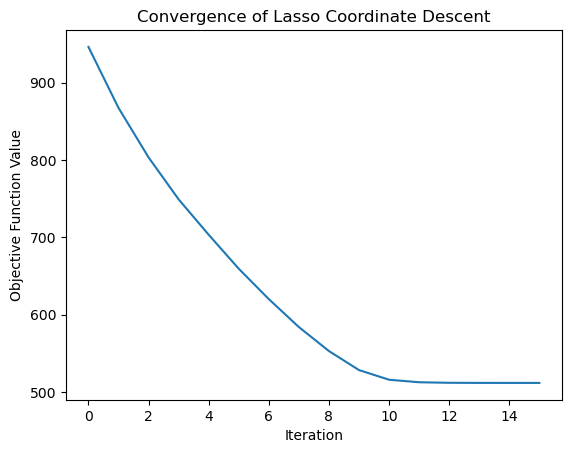

[ 9.79800273e+00 -9.68563056e+00 -9.69063071e+00  9.82989917e+00
  9.94349830e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.18879243e-02
  1.52358387e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -4.40473375e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  4.26609939e-02  0.00000000e+00
 -7.13625305e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.90777959e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

In [231]:
# Sub-Problem 1: run lasso and plot the convergence curve
# TODO: run lasso for one synthetic data
w_lasso, w0_lasso = lasso(X, y, lmda = 10.0, epsilon = 1.0e-2, draw_curve = True, max_iter = 100)
# have a look at the lasso model you got (sparse? where?)
print(w_lasso)

In [232]:
np.where(w_lasso != 0)[0] # This will show the indices of non-zero elements in w_lasso, indicating sparsity

array([ 0,  1,  2,  3,  4, 11, 12, 25, 34, 36, 52, 63, 71])

In [233]:
# Sub-Problem 2
# TODO: evaluation function of lasso model
def Evaluate(X, y, w, w0, w_true, w0_true):
    #########TODO##########
    y_pred = X.dot(w) + w0  # predicted y using the model
    pred_nonzero = np.where(np.abs(w_lasso) > 1e-6)[0]
    true_nonzero = np.where(np.abs(w_true) > 1e-6)[0]
    precision_w = len(np.intersect1d(pred_nonzero, true_nonzero)) / len(pred_nonzero) if len(pred_nonzero) > 0 else 0.0
    recall_w = len(np.intersect1d(pred_nonzero, true_nonzero)) / len(true_nonzero) if len(true_nonzero) > 0 else 0.0
    rmse = np.sqrt(np.mean((y - y_pred)**2))
    sparsity_w = np.sum(np.abs(w) != 0) 
    return (rmse, sparsity_w, precision_w, recall_w)

In [234]:
# Sub-Problem 2
# TODO: apply your evaluation function to compute precision (of w), recall (of w), sparsity (of w) and training RMSE
Emetric = Evaluate(X, y, w_lasso, w0_lasso, w_true, w0_true)
print("Evaluation metrics for Lasso model:")
print("RMSE: {:.4f}".format(Emetric[0]))
print("Sparsity of w: {}".format(Emetric[1]))
print("Precision of w: {:.4f}".format(Emetric[2]))
print("Recall of w: {:.4f}".format(Emetric[3]))


Evaluation metrics for Lasso model:
RMSE: 0.8265
Sparsity of w: 13
Precision of w: 0.3846
Recall of w: 1.0000


In [235]:
# Sub-Problem 3
# TODO: compute a lasso solution path, draw the path(s) in a 2D plot
def LassoPath(X, y):
    #########TODO##########
    n, d = X.shape
    lambda_min = 0
    num_lambda = 50
    lambda_max = np.max(np.abs((y - np.mean(y)).dot(X)))
    Lmda = np.linspace(lambda_min, lambda_max, num = num_lambda)

    W = np.zeros((d, num_lambda))
    W0 = np.zeros(num_lambda)
    for i, lam in enumerate(Lmda):
        w_l, w0_l = lasso(X, y, lmda=lam, epsilon=1.0e-2, max_iter=100, draw_curve=False)
        W[:, i] = w_l
        W0[i] = w0_l
    plt.figure(figsize=(8, 6))
    for j in range(d):
        color = 'red' if j < 5 else 'blue'  # Highlight the first 5 non-zero coefficients in red, others in blue
        plt.plot(Lmda, W[j, :], color=color)

    plt.xlabel('Lambda')
    plt.ylabel('Coefficient Value')
    plt.title('Lasso Solution Path')
    plt.savefig('lasso_solution_path.pdf') # Save the figure to a file
    plt.show() 
    return (W, W0, Lmda)

In [82]:
# Sub-Problem 3
# TODO: evaluate a given lasso solution path, draw plot of precision/recall vs. lambda
import matplotlib.pyplot as plt
from functools import wraps

def EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda):
    #########TODO##########
    n, d = X.shape
    num_lambda = len(Lmda)
    RMSE = np.zeros(num_lambda)
    Sparsity = np.zeros(num_lambda)
    Precision = np.zeros(num_lambda)
    Recall = np.zeros(num_lambda)
    threshold = 1e-6
    true_nonzero = np.where(np.abs(w_true) > threshold)[0]
    for i in range(num_lambda):
        y_pred = X.dot(W[:, i]) + W0[i]
        RMSE[i] = np.sqrt(np.mean((y - y_pred) ** 2))
        Sparsity[i] = np.sum(np.abs(W[:, i]) < threshold) / float(d)
        pred_nonzero = np.where(np.abs(W[:, i]) > threshold)[0]
        if len(pred_nonzero) == 0:
            Precision[i] = 1.0 if len(true_nonzero) == 0 else 0.0
        else:
            Precision[i] = len(np.intersect1d(pred_nonzero, true_nonzero)) / float(len(pred_nonzero))
        if len(true_nonzero) == 0:
            Recall[i] = 1.0
        else:
            Recall[i] = len(np.intersect1d(pred_nonzero, true_nonzero)) / float(len(true_nonzero))
    plt.figure(figsize=(8, 6))
    plt.plot(Lmda, Precision, label='Precision')
    plt.plot(Lmda, Recall, label='Recall')
    plt.xlabel('Lambda')
    plt.ylabel('Score')
    plt.title('Precision and Recall vs. Lambda')
    plt.legend()
    plt.savefig('lasso_precision_recall_vs_lambda.pdf') # Save the figure to a file
    plt.show()
    return (RMSE, Sparsity, Precision, Recall)

Converged at iteration 1
Converged at iteration 15
Converged at iteration 10
Converged at iteration 9
Converged at iteration 8
Converged at iteration 7
Converged at iteration 7
Converged at iteration 7
Converged at iteration 7
Converged at iteration 7
Converged at iteration 7
Converged at iteration 6
Converged at iteration 6
Converged at iteration 6
Converged at iteration 6
Converged at iteration 6
Converged at iteration 6
Converged at iteration 6
Converged at iteration 6
Converged at iteration 6
Converged at iteration 6
Converged at iteration 6
Converged at iteration 6
Converged at iteration 6
Converged at iteration 6
Converged at iteration 6
Converged at iteration 6
Converged at iteration 6
Converged at iteration 5
Converged at iteration 5
Converged at iteration 5
Converged at iteration 5
Converged at iteration 5
Converged at iteration 6
Converged at iteration 6
Converged at iteration 6
Converged at iteration 6
Converged at iteration 6
Converged at iteration 4
Converged at iteration 

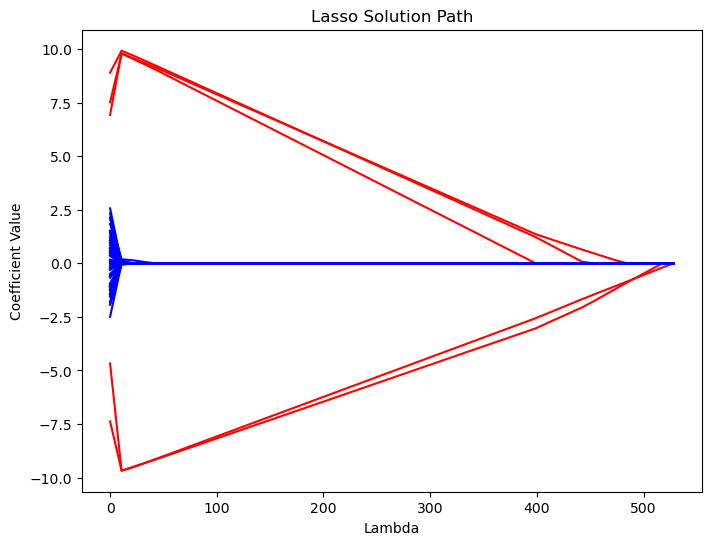

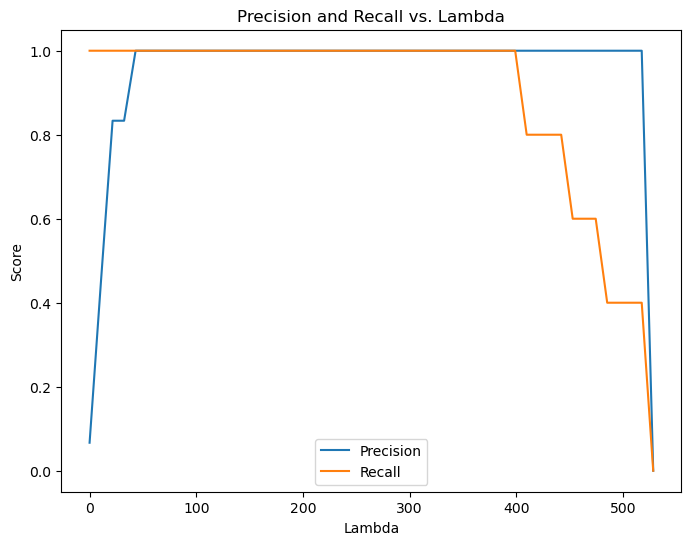

(array([3.11701917e-04, 8.57704056e-01, 1.26487632e+00, 1.68990287e+00,
        2.14562643e+00, 2.60915482e+00, 3.08242216e+00, 3.56159769e+00,
        4.04453783e+00, 4.53004629e+00, 5.01738406e+00, 5.50603498e+00,
        5.99572867e+00, 6.48622966e+00, 6.97732952e+00, 7.46892421e+00,
        7.96092129e+00, 8.45324587e+00, 8.94584458e+00, 9.43868224e+00,
        9.93172311e+00, 1.04249373e+01, 1.09183016e+01, 1.14117952e+01,
        1.19054062e+01, 1.23991286e+01, 1.28929370e+01, 1.33868232e+01,
        1.38804304e+01, 1.43744716e+01, 1.48685586e+01, 1.53626967e+01,
        1.58568812e+01, 1.63513778e+01, 1.68456287e+01, 1.73399138e+01,
        1.78342308e+01, 1.83285766e+01, 1.87343470e+01, 1.91404882e+01,
        1.95484043e+01, 1.99575936e+01, 2.02924901e+01, 2.05980103e+01,
        2.09060948e+01, 2.12008151e+01, 2.14319671e+01, 2.16656514e+01,
        2.19018648e+01, 2.19995675e+01]),
 array([0.        , 0.85333333, 0.92      , 0.92      , 0.93333333,
        0.93333333, 0.9333

In [237]:
# Sub-Problem 3
# TODO: draw lasso solution path and precision/recall vs. lambda curves
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0)
W, W0, Lmda = LassoPath(X, y) # compute the lasso solution path
EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda) # evaluate the solution path and draw precision/recall curves

Converged at iteration 1
Converged at iteration 44
Converged at iteration 40
Converged at iteration 28
Converged at iteration 23
Converged at iteration 17
Converged at iteration 14
Converged at iteration 12
Converged at iteration 9
Converged at iteration 8
Converged at iteration 8
Converged at iteration 7
Converged at iteration 7
Converged at iteration 7
Converged at iteration 7
Converged at iteration 7
Converged at iteration 7
Converged at iteration 7
Converged at iteration 7
Converged at iteration 7
Converged at iteration 7
Converged at iteration 7
Converged at iteration 7
Converged at iteration 7
Converged at iteration 6
Converged at iteration 6
Converged at iteration 6
Converged at iteration 6
Converged at iteration 6
Converged at iteration 6
Converged at iteration 6
Converged at iteration 6
Converged at iteration 6
Converged at iteration 6
Converged at iteration 6
Converged at iteration 6
Converged at iteration 6
Converged at iteration 5
Converged at iteration 5
Converged at itera

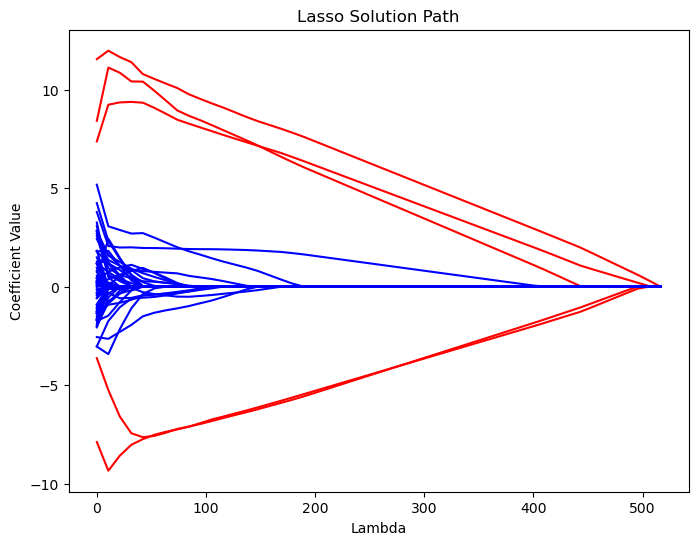

In [238]:
# Sub-Problem 3
# TODO: try a larger std sigma = 10.0
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=10.0)
W, W0, Lmda = LassoPath(X, y) # compute the lasso solution path for larger sigma

In [239]:
w_true

array([ 10., -10., -10.,  10.,  10.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])

In [240]:
# Sub-Problem 1 (modified for Q4)
# TODO: coordinate descent of lasso, note lmda stands for lambda
def lassoQ4(X, y, lmda = 10.0, epsilon = 1.0e-2, max_iter = 100, draw_curve = False):
    #########TODO##########
    n, d = X.shape
    w, w0 = Initialw(X, y)
    w_old = w.copy()
    obj_values = []
    for t in range(max_iter):
        w0 = np.mean(y - X.dot(w))
        for j in range(d):
            r_j = y - (X.dot(w) + w0) + X[:, j] * w[j]
            c_j = np.dot(X[:, j], r_j)
            a_j = (X[:, j] ** 2).sum()
            if c_j < -lmda:
                w[j] = (c_j + lmda) / a_j
            elif c_j > lmda:
                w[j] = (c_j - lmda) / a_j
            else:
                w[j] = 0.0
        y_pred = X.dot(w) + w0
        residual = y - y_pred
        obj = 0.5 * np.sum(residual ** 2) + lmda * np.sum(np.abs(w))
        obj_values.append(obj)
        max_w_change = np.max(np.abs(w - w_old))
        if max_w_change <= epsilon:
            # print("Converged at iteration", t+1)
            break
        w_old = w.copy()
    if draw_curve:
        import matplotlib.pyplot as plt
        plt.figure()
        plt.plot(obj_values)
        plt.xlabel('Iteration')
        plt.ylabel('Objective Function Value')
        plt.title('Convergence of Lasso Coordinate Descent')
        plt.savefig('lasso_convergence.pdf') # Save the figure to a file
        plt.show()
    return w, w0

In [241]:
# Sub-Problem 3 (modified for question 4)
# TODO: compute a lasso solution path, draw the path(s) in a 2D plot
def LassoPathQ4(X, y, ax):
    #########TODO##########
    n, d = X.shape
    lambda_min = 0
    num_lambda = 50
    lambda_max = np.max(np.abs((y - np.mean(y)).dot(X)))
    Lmda = np.linspace(lambda_min, lambda_max, num = num_lambda)

    W = np.zeros((d, num_lambda))
    W0 = np.zeros(num_lambda)
    for i, lam in enumerate(Lmda):
        w_l, w0_l = lassoQ4(X, y, lmda=lam, epsilon=1.0e-2, max_iter=100, draw_curve=False)
        W[:, i] = w_l
        W0[i] = w0_l
    # plt.figure(figsize=(8, 6))
    for j in range(d):
        color = 'red' if j < 5 else 'blue'  # Highlight the first 5 non-zero coefficients in red, others in blue
        ax.plot(Lmda, W[j, :], color=color)

    ax.set_xlabel('Lambda')
    ax.set_ylabel('Coefficient Value')
    ax.set_title(f'Lasso Solution Path (n={n}, m={d})')
    return (W, W0, Lmda)

In [242]:
# Sub-Problem 3 (modified for Q4)
# TODO: evaluate a given lasso solution path, draw plot of precision/recall vs. lambda
import matplotlib.pyplot as plt
from functools import wraps

def EvaluatePathQ4(X, y, W, W0, w_true, w0_true, Lmda, ax):
    #########TODO##########
    n, d = X.shape
    num_lambda = len(Lmda)
    RMSE = np.zeros(num_lambda)
    Sparsity = np.zeros(num_lambda)
    Precision = np.zeros(num_lambda)
    Recall = np.zeros(num_lambda)
    threshold = 1e-6
    true_nonzero = np.where(np.abs(w_true) > threshold)[0]
    for i in range(num_lambda):
        y_pred = X.dot(W[:, i]) + W0[i]
        RMSE[i] = np.sqrt(np.mean((y - y_pred) ** 2))
        Sparsity[i] = np.sum(np.abs(W[:, i]) < threshold) / float(d)
        pred_nonzero = np.where(np.abs(W[:, i]) > threshold)[0]
        if len(pred_nonzero) == 0:
            Precision[i] = 1.0 if len(true_nonzero) == 0 else 0.0
        else:
            Precision[i] = len(np.intersect1d(pred_nonzero, true_nonzero)) / float(len(pred_nonzero))
        if len(true_nonzero) == 0:
            Recall[i] = 1.0
        else:
            Recall[i] = len(np.intersect1d(pred_nonzero, true_nonzero)) / float(len(true_nonzero))
    opt = np.where((Precision == 1) & (Recall == 1))
    print("Optimal lambdas:" , Lmda[opt] if len(opt[0]) > 0 else "None found precision and recall both 1")
    # Calculate the optimal lambda by finding all the max sum 
    maxlmda =  np.max(Precision + Recall)
    maxlmda = Lmda[np.where((Precision + Recall) == maxlmda)[0]] if len(np.where((Precision + Recall) == maxlmda)[0]) > 0 else None
    # output all lambda that equals to the max Precision + Recall
    print(f"Optimal lambda based on max Precision + Recall: {maxlmda}")
    ax.plot(Lmda, Precision, label='Precision')
    ax.plot(Lmda, Recall, label='Recall')
    ax.set_xlabel('Lambda')
    ax.set_ylabel('Score')
    ax.set_title('Precision and Recall vs. Lambda (n={}, m={})'.format(n, d))
    ax.legend()
    return (RMSE, Sparsity, Precision, Recall)

In [243]:
# Sub-Problem 4
# TODO: try another 5 different choices of (n,d)
# draw lasso solution path and precision/recall vs. lambda curves, use them to estimate the lasso sample complexity
fig, axs = plt.subplots(2, 3, figsize=(24, 12))
fig1, axs1 = plt.subplots(2, 3, figsize=(24, 12)) 
settings = [(50, 75), (50, 150), (50, 1000), (100, 75), (100,150), (100, 1000)]
settings = [(50, 1000)]
for i, (n, d) in enumerate(settings):
    print("Running for n={}, d={}".format(n, d))
    X, y, w_true, w0_true = DataGenerator(n=n, d=d, k=5, sigma=1.0)
    W, W0, Lmda = LassoPathQ4(X, y, ax = axs[i//3, i%3]) # compute the lasso solution path for given n, d
    EvaluatePathQ4(X, y, W, W0, w_true, w0_true, Lmda, ax=axs1[i//3, i%3]) # evaluate the solution path and draw precision/recall curves
fig.savefig('test.pdf') # Save the figure to a file
fig1.savefig('eval_precision_recall_vs_lambda.pdf') # Save the figure to a file

Running for n=50, d=1000
Optimal lambdas: None found precision and recall both 1
Optimal lambda based on max Precision + Recall: [236.89729865 255.12016777 273.3430369  291.56590603 309.78877515
 328.01164428 346.23451341 364.45738253]


In [ ]:
import numpy as np
from tqdm import tqdm
from scipy.sparse import csc_matrix

def lassoQ5_optimized(X, y, lmda=10.0, epsilon=1.0e-2, max_iter=100):
    if not isinstance(X, csc_matrix):
        X = X.tocsc()
    n, d = X.shape
    w, w0 = Initialw(X, y)
    w_old = w.copy()
    obj_values = []
    a = np.empty(d)
    X_cols = []
    for j in range(d):
        X_j = X[:, j]
        a_j = X_j.power(2).sum()  # a_j = x_j^T * x_j
        a[j] = a_j
        X_cols.append(X_j)
    
    for t in (range(max_iter)):
        w0 = np.mean(y - X.dot(w))
        r = y - (X.dot(w) + w0)
        for j in range(d):
            X_j = X_cols[j]
            a_j = a[j]
            if a_j == 0:
                continue
            old_wj = w[j]
            c_j = X_j.T.dot(r)[0] + old_wj * a_j
            if c_j < -lmda:
                new_wj = (c_j + lmda) / a_j
            elif c_j > lmda:
                new_wj = (c_j - lmda) / a_j
            else:
                new_wj = 0.0
            w[j] = new_wj
            delta_w_j = new_wj - old_wj
            if delta_w_j != 0:
                idx_nz = X_j.indices
                r[idx_nz] -= X_j.data * delta_w_j
        obj = 0.5 * np.sum(r ** 2) + lmda * np.sum(np.abs(w))
        obj_values.append(obj)
        max_w_change = np.max(np.abs(w - w_old))
        if max_w_change <= epsilon:
            # print(f"Converged at iteration {t+1}")
            break
        w_old = w.copy()
    
    return w, w0

In [66]:
# Sub-Problem 5: predict reviews' star on Yelp
# data parser reading yelp data
def DataParser(Xfile, yfile, nfile, train_size = 4000, valid_size = 1000):

    # read X, y, feature names from file
    fName = open(nfile).read().splitlines()
    y = np.loadtxt(yfile, dtype=np.int32)
    if Xfile.find('mtx') >= 0:
        # sparse data
        X = io.mmread(Xfile).tocsc()
    else:
        # dense data
        X = np.genfromtxt(Xfile, delimiter=",")

    # split training, validation and test set
    X_train = X[0 : train_size,:]
    y_train = y[0 : train_size]
    X_valid = X[train_size : train_size + valid_size,:]
    y_valid = y[train_size : train_size + valid_size]
    X_test = X[train_size + valid_size : np.size(X,0),:]
    y_test = y[train_size + valid_size : np.size(y,0)]

    return (X_train, y_train, X_valid, y_valid, X_test, y_test, fName)

In [ ]:
def LassoPathQ5(X, y, num_lambda=20, epsilon=1e-2, max_iter=100):
    n, d = X.shape
    print("Generating Lasso Path for n={}, d={}...".format(n, d))
    W = np.zeros((d, num_lambda))
    # print("Initializing W matrix with zeros, shape: {}".format(W.shape))
    W0 = np.zeros(num_lambda)
    # print("Initializing W0 vector with zeros, shape: {}".format(W0.shape))
    v = y - np.mean(y)
    w = X.T.dot(v)
    lambda_max = np.max(np.abs(w))
    lambda_min = 0.1 * lambda_max 
    # print("lambda_min: {}, lambda_max: {}".format(lambda_min, lambda_max))
    Lmda = np.linspace(lambda_min, lambda_max, num=num_lambda)
    # print("Lmda range generated.")
    # for i, lam in tqdm(enumerate(Lmda)):
    for i in tqdm(range(len(Lmda))):
        lam = Lmda[i]
        print("Processing lambda {}/{}: {}".format(i+1, num_lambda, lam))
        w_l, w0_l = lassoQ5_optimized(X, y, lmda=lam, epsilon=epsilon, max_iter=max_iter)
        W[:, i] = w_l
        W0[i] = w0_l
    plt.figure(figsize=(12, 8))
    for j in range(d):
        # random color for each coefficient line
        plt.plot(Lmda, W[j, :], linewidth=0.5)
    plt.xlabel('Lambda')
    plt.ylabel('Coefficient Value')
    plt.title('Lasso Solution Path')
    plt.savefig('lasso_solution_path.pdf')
    plt.show()
    return (W, W0, Lmda)


In [99]:
def rmseeval(X_valid, y_valid, W, W0, Lmda, X_train, y_train):
    """
    draw the RMSE vs. lambda curve for the lasso solution path
    """
    n, d = X_valid.shape
    num_lambda = len(Lmda)
    RMSE_valid = np.zeros(num_lambda)
    RMSE_train = np.zeros(num_lambda)
    for i in range(num_lambda):
        # Predict on validation set
        y_pred_valid = X_valid.dot(W[:, i]) + W0[i]
        RMSE_valid[i] = np.sqrt(np.mean((y_valid - y_pred_valid) ** 2))
        
        # Predict on training set
        y_pred_train = X_train.dot(W[:, i]) + W0[i]
        RMSE_train[i] = np.sqrt(np.mean((y_train - y_pred_train) ** 2))
    plt.figure(figsize=(12, 8))
    plt.plot(Lmda, RMSE_valid, label='Validation RMSE', marker='o', linewidth=2)
    plt.plot(Lmda, RMSE_train, label='Training RMSE', marker='x', linewidth=2)
    plt.xlabel('Lambda')
    plt.ylabel('RMSE')
    plt.title('RMSE vs. Lambda for Lasso Regression')
    plt.legend()
    plt.grid(True)
    plt.savefig('lasso_rmse_vs_lambda.pdf') # Save the figure to a file
    plt.show()
    return RMSE_valid

In [113]:
# Sub-Problem 5: predict reviews' star on Yelp
# TODO: evaluation funtion that computes the lasso path, evaluates the result, and draws the required plots
def Validation(X_train, y_train, X_valid, y_valid):
    #########TODO##########
    lmda_best = None
    # draw the RMSE 
    W, W0, Lmda = LassoPathQ5(X_train, y_train)
    # Evaluate the path on validation set
    RMSE = rmseeval(X_valid, y_valid, W, W0, Lmda, X_train, y_train)
    # Find the best lambda based on the validation RMSE
    min_rmse_index = np.argmin(RMSE)
    min_RMSE = RMSE.min()
    if min_rmse_index >= 0 and min_rmse_index < len(Lmda):
        lmda_best = Lmda[min_rmse_index]
        print("Best lambda found at index {}: {}".format(min_rmse_index, lmda_best))
    else:
        print("No valid lambda found for the given RMSE.")
    best_w = W[:, min_rmse_index] if lmda_best is not None else None
    best_w0 = W0[min_rmse_index] if lmda_best is not None else None
    return (best_w, best_w0, lmda_best, min_RMSE)

(30000, 2500) (30000,) (5000, 2500) (5000,) (10000, 2500) (10000,)
Generating Lasso Path for n=30000, d=2500...


  0%|          | 0/20 [00:00<?, ?it/s]

Processing lambda 1/20: 3.95782540136483


  5%|▌         | 1/20 [00:03<01:15,  3.98s/it]

Processing lambda 2/20: 5.832584802011328


 10%|█         | 2/20 [00:07<01:02,  3.47s/it]

Processing lambda 3/20: 7.7073442026578265


 15%|█▌        | 3/20 [00:09<00:52,  3.11s/it]

Processing lambda 4/20: 9.582103603304326


 20%|██        | 4/20 [00:12<00:47,  2.94s/it]

Processing lambda 5/20: 11.456863003950822


 25%|██▌       | 5/20 [00:15<00:42,  2.82s/it]

Processing lambda 6/20: 13.331622404597322


 30%|███       | 6/20 [00:17<00:37,  2.71s/it]

Processing lambda 7/20: 15.206381805243819


 35%|███▌      | 7/20 [00:20<00:34,  2.63s/it]

Processing lambda 8/20: 17.08114120589032


 40%|████      | 8/20 [00:22<00:31,  2.59s/it]

Processing lambda 9/20: 18.955900606536815


 45%|████▌     | 9/20 [00:24<00:28,  2.55s/it]

Processing lambda 10/20: 20.83066000718331


 50%|█████     | 10/20 [00:27<00:25,  2.53s/it]

Processing lambda 11/20: 22.70541940782981


 55%|█████▌    | 11/20 [00:29<00:22,  2.48s/it]

Processing lambda 12/20: 24.58017880847631


 60%|██████    | 12/20 [00:31<00:18,  2.35s/it]

Processing lambda 13/20: 26.45493820912281


 65%|██████▌   | 13/20 [00:33<00:15,  2.26s/it]

Processing lambda 14/20: 28.329697609769305


 70%|███████   | 14/20 [00:35<00:13,  2.18s/it]

Processing lambda 15/20: 30.204457010415805


 75%|███████▌  | 15/20 [00:37<00:10,  2.12s/it]

Processing lambda 16/20: 32.079216411062305


 80%|████████  | 16/20 [00:39<00:08,  2.06s/it]

Processing lambda 17/20: 33.9539758117088


 85%|████████▌ | 17/20 [00:41<00:06,  2.06s/it]

Processing lambda 18/20: 35.8287352123553


 90%|█████████ | 18/20 [00:43<00:04,  2.02s/it]

Processing lambda 19/20: 37.703494613001794


 95%|█████████▌| 19/20 [00:45<00:02,  2.03s/it]

Processing lambda 20/20: 39.5782540136483


100%|██████████| 20/20 [00:47<00:00,  2.39s/it]


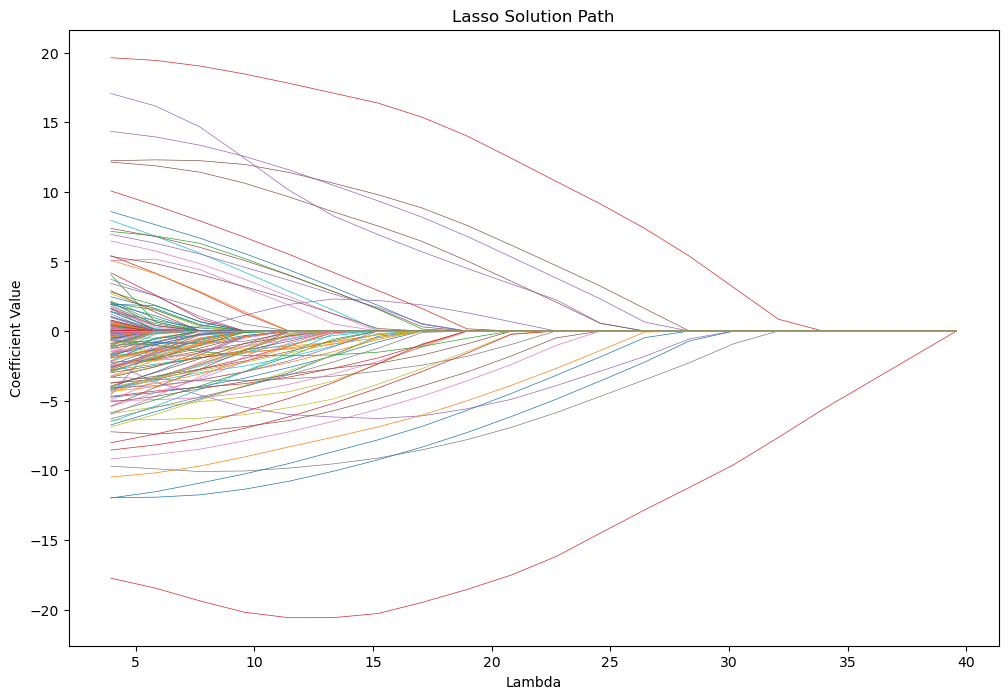

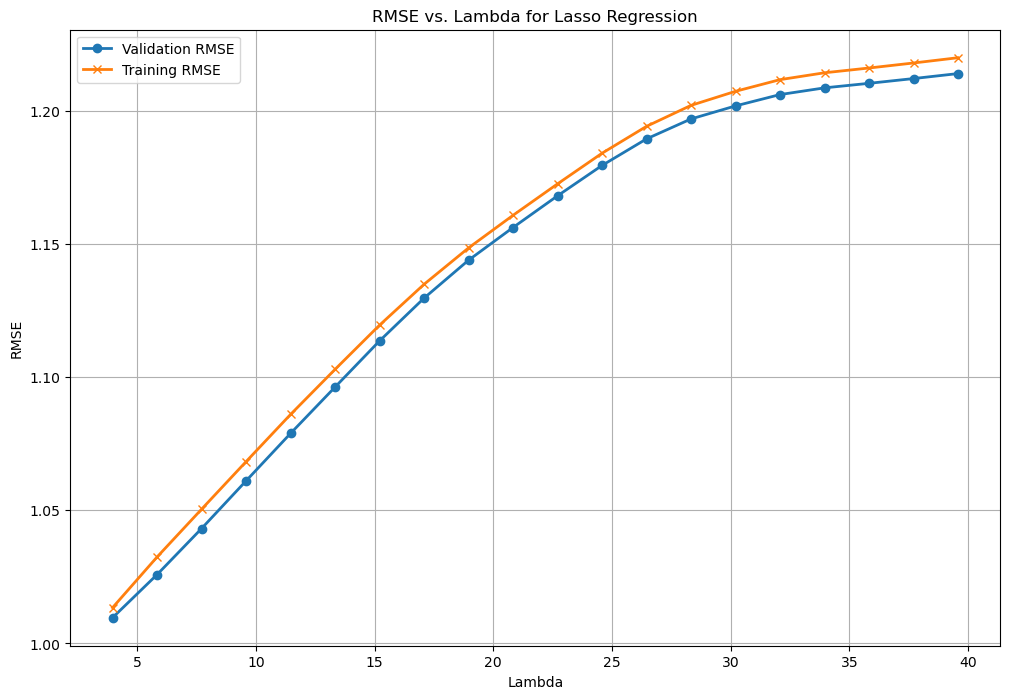

Best lambda found at index 0: 3.95782540136483
rmse: 1.0096512302660232
Lasso select features:
great 19.626910602812263
not -17.746498530426216
best 17.05719025532021
amazing 14.339641440305963
love 12.228556228270259
delicious 12.132458330783074
rude -11.989863473044203
the worst -11.959659903513517
horrible -10.486167300825196
awesome 10.058457548734463


In [114]:
# Sub-Problem 5: predict reviews' star on Yelp
# TODO: evaluation of your results

# load Yelp data: change the address of data files on your own machine if necessary ('./data/' in the below)
import numpy as np
from scipy.sparse.linalg import lsqr
X_train, y_train, X_valid, y_valid, X_test, y_test, fName = DataParser('./data/star_data.mtx', './data/star_labels.txt', './data/star_features.txt', 30000, 5000)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)
# evaluation
w_lasso, w0_lasso, lmda_best, min_rmse = Validation(X_train, y_train, X_valid, y_valid)
print(f"rmse: {min_rmse}")
# print the top-10 features you found by lasso
idx = (-np.abs(w_lasso)).argsort()[0:10]
print('Lasso select features:')
for i in range(10):
    print(fName[idx[i]],w_lasso[idx[i]])